In [ ]:
import keras

import matplotlib.gridspec as gridspec
from tqdm.notebook import trange, tqdm

from models.VLAE import VLAE
from models.VAE import VAE


vae_gan_mnist = keras.models.load_model("/Users/leo/Downloads/vae_gan_mnist.h5")
vae_gan_mnist_decoder = vae_gan_mnist.layers[-1]
vae_gan_mnist_encoder = keras.Model(vae_gan_mnist.layers[0].input, vae_gan_mnist.layers[-2].output)

vlae_gan_mnist = keras.models.load_model("/Users/leo/Downloads/vlae_gan_mnist.h5")
vlae_gan_mnist_decoder = vlae_gan_mnist.layers[-1]
vlae_gan_mnist_encoder = keras.Model(vlae_gan_mnist.layers[0].input, (vlae_gan_mnist.layers[-4].output, vlae_gan_mnist.layers[-3].output, vlae_gan_mnist.layers[-2].output))

Using TensorFlow backend.


In [ ]:
vlae_gan_mnist_encoder.summary()

In [ ]:
vlae = VLAE(input_dim=(28,28,1),
            inf0_kernels_strides_featuremaps=[(5, 2, 64)],
            inf1_kernels_strides_featuremaps=[(3, 2, 64)],
            ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
            ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
            ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
            gen2_num_units=[1024, 1024],
            gen1_num_units=[1024, 1024],
            gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
            use_dropout=False, use_batch_norm=False, log_dir="logs",kernel_visualization_layer=1, num_samples=1,
            feature_map_layers=[], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=1, z_dims=[2,2,2])
vlae.load_weights("/Users/leo/Downloads/vlae_28_mnist.h5")

vae = VAE(input_dim=(28,28,1), encoder_conv_filters=[32, 64, 64, 64],
          encoder_conv_kernel_size=[3, 3, 3, 3],
          encoder_conv_strides=[2, 2, 1, 1],
          decoder_conv_t_filters=[64, 64, 32, 1],
          decoder_conv_t_kernel_size=[3, 3, 3, 3],
          decoder_conv_t_strides=[1, 1, 2, 2],
          log_dir='logs',
          z_dims=[2],
          kernel_visualization_layer=1,
          feature_map_layers=[], use_batch_norm=False,
          use_dropout=False,
          decay_rate=.0, num_samples=5,
          feature_map_reduction_factor=1,
          inner_activation="ReLU", dropout_rate=.0)
vae.load_weights("/Users/leo/Documents/Tesla/vae/master-thesis-leonard/logs_vae_28_mnist_20-06-2020/weights/weights.h5")

In [ ]:
import numpy as np
columns = 20
from matplotlib import pyplot as plt
rows = 20
zs = []

for i in range(-30, 30,3):
    for j in range(-30, 30,3):
        z1 = np.zeros((1,2))
        z1[0] = np.array([i/10, j/10])
        zs.append(z1)


In [ ]:
fig = plt.figure(figsize=(27, 9))
outer = fig.add_gridspec(1, 3, wspace=0.2, hspace=0.2)


for col in trange(3):
    inner = outer[col].subgridspec(20, 20, wspace=0.1, hspace=0.1)
    for i in range(400):
        ax = fig.add_subplot(inner[i])
        z = [np.random.uniform(-3,3,(1,2))] * 3
        z[col] = zs[i]
        img = vlae_gan_mnist_decoder.predict(z).squeeze()
        ax.imshow(1.0 - img, cmap='gray')
        ax.axis('off')
        fig.add_subplot(ax)
plt.show()


In [ ]:
fig = plt.figure(figsize=(27, 9))
outer = fig.add_gridspec(1, 3, wspace=0.2, hspace=0.2)


for col in trange(3):
    inner = outer[col].subgridspec(20, 20, wspace=0.1, hspace=0.1)
    for i in range(400):
        ax = fig.add_subplot(inner[i])
        z = [np.random.uniform(-3,3,(1,2))] * 3
        z[col] = zs[i]
        img = vlae.decoder.predict(z).squeeze()
        ax.imshow(1.0 - img, cmap='gray')
        ax.axis('off')
        fig.add_subplot(ax)
plt.show()

In [ ]:
fig = plt.figure(figsize=(9, 9))

for i in trange(400):
    z = zs[i]
    img = vae.decoder.predict(z).squeeze()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(1.0 - img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
fig = plt.figure(figsize=(9, 9))

for i in trange(400):
    z = zs[i]
    img = vae_gan_mnist_decoder.predict(z).squeeze()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(1.0 - img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
from keras.datasets import mnist

(mnist_train_x, mnist_train_y), (mnist_val_x, mnist_val_y) = mnist.load_data()




In [ ]:
vlae_predictions = np.array(vlae.encoder.predict(np.expand_dims(mnist_val_x / 255., -1)))
vlae_kdes = np.array([[stats.gaussian_kde(vlae_predictions[i, :, j]) for j in range(vlae_predictions.shape[-1])] for i in trange(vlae_predictions.shape[0])])
vlae_latent_samples = np.array([[vlae_kdes[i,j].resample(10000).ravel() for j in range(vlae_kdes.shape[1])] for i in trange(vlae_kdes.shape[0])])
vlae_latent_samples = np.swapaxes(vlae_latent_samples, 1, -1)

vlae_gan_predictions = np.array(vlae_gan_mnist_encoder.predict(np.expand_dims(mnist_val_x / 255., -1)))
vlae_gan_kdes = np.array([[stats.gaussian_kde(vlae_gan_predictions[i, :, j]) for j in range(vlae_gan_predictions.shape[-1])] for i in trange(vlae_gan_predictions.shape[0])])
vlae_gan_latent_samples = np.array([[vlae_gan_kdes[i,j].resample(10000).ravel() for j in range(vlae_gan_kdes.shape[1])] for i in trange(vlae_gan_kdes.shape[0])])
vlae_gan_latent_samples = np.swapaxes(vlae_gan_latent_samples, 1, -1)



In [ ]:
vae_predictions = np.array(vae.encoder.predict(np.expand_dims(mnist_val_x / 255., -1)))
vae_kdes = np.array([stats.gaussian_kde(vae_predictions[:, i]) for i in range(vae_predictions.shape[-1])])
vae_latent_samples = np.array([vae_kdes[i].resample(10000).ravel() for i in range(vae_kdes.shape[0])])
vae_latent_samples = np.swapaxes(vae_latent_samples, 0, -1)

vae_gan_predictions = np.array(vae_gan_mnist_encoder.predict(np.expand_dims(mnist_val_x / 255., -1)))
vae_gan_kdes = np.array([stats.gaussian_kde(vae_gan_predictions[:, i]) for i in range(vae_gan_predictions.shape[-1])])
vae_gan_latent_samples = np.array([vae_gan_kdes[i].resample(10000).ravel() for i in range(vae_gan_kdes.shape[0])])
vae_gan_latent_samples = np.swapaxes(vae_gan_latent_samples, 0, -1)

In [ ]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 6*sigma, mu + 6*sigma, 400)

fig = plt.figure(figsize=(vlae_gan_kdes.shape[1]*5, vlae_gan_kdes.shape[0]*5))
i=1
for layer in range(vlae_gan_predictions.shape[0]):
    for idm in range(vlae_gan_predictions.shape[-1]):
        fig.add_subplot(vlae_gan_kdes.shape[0], vlae_gan_kdes.shape[1], i)
        plt.title("Layer {} - {}. Dimension".format(layer, idm))
        plt.hist(vlae_gan_predictions[layer,:,idm], bins=100, density=True)
        plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=0.7)
        plt.plot(x, vlae_gan_kdes[layer, idm](x).squeeze(), alpha=0.7, color='red')
        i+=1
plt.show()

In [ ]:
import math
import scipy


mmin = min(vlae_predictions.min(), vlae_gan_predictions.min(), vae_predictions.min(), vae_gan_predictions.min())
mmax = max(vlae_predictions.max(), vlae_gan_predictions.max(), vae_predictions.max(), vae_gan_predictions.max())

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu + mmin*sigma, mu + mmax*sigma, 500)

fig = plt.figure(figsize=(vlae_kdes.shape[1]*5, vlae_kdes.shape[0]*5))
i=1
print(vlae_kdes.shape[0]*5)
for layer in range(vlae_kdes.shape[0]):
    for dimension in range(vlae_kdes.shape[1]):
        fig.add_subplot(vlae_kdes.shape[0], vlae_kdes.shape[1], i)
        plt.title("VLAE Layer {} - {}. Dimension".format(layer+1, dimension+1))
        plt.hist(vlae_predictions[layer,:,dimension], bins=100, density=True, alpha=0.3)
        plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=1.)
        plt.plot(x, vlae_kdes[layer, dimension](x).squeeze(), alpha=1.)
        i+=1
plt.show()

fig = plt.figure(figsize=(vlae_gan_kdes.shape[1]*5, vlae_gan_kdes.shape[0]*5))
i=1
for layer in range(vlae_gan_kdes.shape[0]):
    for dimension in range(vlae_gan_kdes.shape[1]):
        fig.add_subplot(vlae_gan_kdes.shape[0], vlae_gan_kdes.shape[1], i)
        plt.title("VLAE-GAN Layer {} - {}. Dimension".format(layer+1, dimension+1))
        plt.hist(vlae_gan_predictions[layer,:,dimension], bins=100, density=True, alpha=0.3)
        plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=1.)
        plt.plot(x, vlae_gan_kdes[layer, dimension](x).squeeze(), alpha=1.)
        i+=1
plt.show()
print(vae_kdes.shape[0]*8)
fig = plt.figure(figsize=(vae_kdes.shape[0]*8, 5))
i=1
for layer in range(1):
    for dimension in range(vae_kdes.shape[0]):
        fig.add_subplot(1, vlae_gan_kdes.shape[0], i)
        plt.title("VAE Layer {} - {}. Dimension".format(layer+1, dimension+1))
        plt.hist(vae_predictions[:,dimension], bins=100, density=True, alpha=0.3)
        plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=1.)
        plt.plot(x, vae_kdes[dimension](x).squeeze(), alpha=1.)
        i+=1
plt.show()

fig = plt.figure(figsize=(vae_kdes.shape[0]*8, 5))
i=1
for layer in range(1):
    for dimension in range(vae_kdes.shape[0]):
        fig.add_subplot(1, vlae_gan_kdes.shape[0], i)
        plt.title("VAE-GAN Layer {} - {}. Dimension".format(layer+1, dimension+1))
        plt.hist(vae_gan_predictions[:,dimension], bins=100, density=True, alpha=0.3)
        plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=1.)
        plt.plot(x, vae_gan_kdes[dimension](x).squeeze(), alpha=1.)
        i+=1
plt.show()

In [ ]:
from keras.datasets import mnist
import numpy as np
from sklearn.utils import shuffle
import scipy as sp
from utils.img_ops import resize_array

(_,_),(mnists,_) = mnist.load_data()
mnists = shuffle(mnists)
mnists = mnists.reshape((mnists.shape[0], -1))
mnist_mean = np.mean(mnists, axis=1)
mnist_sd = np.std(mnists, axis=1)
mnist_skew = sp.stats.skew(mnists, axis=1)
mnist_kurt = sp.stats.kurtosis(mnists, axis=1)


vlae_gens = vlae.decoder.predict(list(vlae_predictions)).squeeze()
vlae_gens = np.stack(vlae_gens)
vlae_gens *= 255.0
vlae_gens = vlae_gens.reshape(vlae_gens.shape[0], -1)
vlae_gens_mean = np.mean(vlae_gens, axis=1)
vlae_gens_sd = np.std(vlae_gens, axis=1)
vlae_gens_skew = sp.stats.skew(vlae_gens, axis=1)
vlae_gens_kurt = sp.stats.kurtosis(vlae_gens, axis=1)

vlaegan_gens = vlae_gan_mnist_decoder.predict(list(vlae_gan_predictions)).squeeze()
vlaegan_gens = np.stack(vlaegan_gens)
vlaegan_gens *= 255.0
vlaegan_gens = vlaegan_gens.reshape(vlaegan_gens.shape[0], -1)
vlaegan_gens_mean = np.mean(vlaegan_gens, axis=1)
vlaegan_gens_sd = np.std(vlaegan_gens, axis=1)
vlaegan_gens_skew = sp.stats.skew(vlaegan_gens, axis=1)
vlaegan_gens_kurt = sp.stats.kurtosis(vlaegan_gens, axis=1)

vaegan_gens = vae_gan_mnist_decoder.predict(vae_gan_latent_samples).squeeze()
vaegan_gens = np.stack(vaegan_gens)
vaegan_gens *= 255.0
vaegan_gens = vaegan_gens.reshape(vaegan_gens.shape[0], -1)
vaegan_gens_mean = np.mean(vaegan_gens, axis=1)
vaegan_gens_sd = np.std(vaegan_gens, axis=1)
vaegan_gens_skew = sp.stats.skew(vaegan_gens, axis=1)
vaegan_gens_kurt = sp.stats.kurtosis(vaegan_gens, axis=1)

vae_gens = vae.decoder.predict(vae_latent_samples).squeeze()
vae_gens = np.stack(vae_gens)
vae_gens *= 255.0
vae_gens = resize_array(vae_gens, (28,28), False)
vae_gens = vae_gens.reshape(vae_gens.shape[0], -1)
vae_gens_mean = np.mean(vae_gens, axis=1)
vae_gens_sd = np.std(vae_gens, axis=1)
vae_gens_skew = sp.stats.skew(vae_gens, axis=1)
vae_gens_kurt = sp.stats.kurtosis(vae_gens, axis=1)

In [ ]:
import statsmodels as sm


def compare_image_sets(set1, set2):

    p_values = []
    skipped_sets = 0

    for pxl in range(vae_gens.shape[-1]):
        arr1 = set1[:, pxl]
        arr2 = set2[:, pxl]
        if np.array_equal(arr1, arr2):
            skipped_sets += 1
            continue
        s, p = sp.stats.mannwhitneyu(arr1, arr2)
        p_values.append(p)

    res = sm.stats.multitest.multipletests(p_values, method='fdr_bh',alpha=0.01)
    reject, accept = np.where(res[0] == True)[0], np.where(res[0] == False)[0]
    reject, accept = len(reject), len(accept)
    overall = len(res[0])
    return "Reject {}, Accept {} of {}, Skipped {}".format(reject, accept, overall, skipped_sets)
    

In [ ]:
import scipy as sp

print("vae",compare_image_sets(mnists, vae_gens))
print("vae mean",sp.stats.mannwhitneyu(mnist_mean, vae_gens_mean))
print("vae sd",sp.stats.mannwhitneyu(mnist_sd, vae_gens_sd))
print("vae skew",sp.stats.mannwhitneyu(mnist_skew, vae_gens_skew))
print("vae kurt",sp.stats.mannwhitneyu(mnist_kurt, vae_gens_kurt))
print('---')
print("vlae",compare_image_sets(mnists, vlae_gens))
print("vlae mean",sp.stats.mannwhitneyu(mnist_mean, vlae_gens_mean))
print("vlae sd",sp.stats.mannwhitneyu(mnist_sd, vlae_gens_sd))
print("vlae skew",sp.stats.mannwhitneyu(mnist_skew, vlae_gens_skew))
print("vlae kurt",sp.stats.mannwhitneyu(mnist_kurt, vlae_gens_kurt))
print('---')
print("vlae gan mean",compare_image_sets(mnists, vlaegan_gens))
print("vlae gan mean",sp.stats.mannwhitneyu(mnist_mean, vlaegan_gens_mean))
print("vlae gan sd",sp.stats.mannwhitneyu(mnist_sd, vlaegan_gens_sd))
print("vlae gan skew",sp.stats.mannwhitneyu(mnist_skew, vlaegan_gens_skew))
print("vlae gan kurt",sp.stats.mannwhitneyu(mnist_kurt, vlaegan_gens_kurt))
print('---')
print("vae gan mean",compare_image_sets(mnists, vaegan_gens))
print("vae gan mean",sp.stats.mannwhitneyu(mnist_mean, vaegan_gens_mean))
print("vae gan sd",sp.stats.mannwhitneyu(mnist_sd, vaegan_gens_sd))
print("vae gan skew",sp.stats.mannwhitneyu(mnist_skew, vaegan_gens_skew))
print("vae gan kurt",sp.stats.mannwhitneyu(mnist_kurt, vaegan_gens_kurt))

In [ ]:
from matplotlib import pyplot as plt

bins = 100
plt.title("Mean")
plt.hist(vlae_gens_mean, bins, alpha=0.5, label="VLAE generated", density=True)
plt.hist(vlaegan_gens_mean, bins, alpha=0.5, label="VLAE GAN generated", density=True)
plt.hist(vaegan_gens_mean, bins, alpha=0.5, label="VAE GAN generated", density=True)
plt.hist(vae_gens_mean, bins, alpha=0.5, label="VAE generated", density=True)
plt.hist(mnist_mean, bins, alpha=0.5, label="true", density=True)
plt.legend()
plt.show()
plt.close()
plt.title("Standard Deviation")
plt.hist(vlae_gens_sd, bins, alpha=0.5, label="VLAE generated", density=True)
plt.hist(vlaegan_gens_sd, bins, alpha=0.5, label="VLAE GAN generated", density=True)
plt.hist(vaegan_gens_sd, bins, alpha=0.5, label="VAE GAN generated", density=True)
plt.hist(vae_gens_sd, bins, alpha=0.5, label="VAE generated", density=True)
plt.hist(mnist_sd, bins, alpha=0.5, label="true", density=True)
plt.legend()
plt.show()
plt.close()
plt.title("Skewness")
plt.hist(vlae_gens_skew, bins, alpha=0.5, label="VLAE generated", density=True)
plt.hist(vlaegan_gens_skew, bins, alpha=0.5, label="VLAE GAN generated", density=True)
plt.hist(vaegan_gens_skew, bins, alpha=0.5, label="VAE GAN generated", density=True)
plt.hist(vae_gens_skew, bins, alpha=0.5, label="VAE generated", density=True)
plt.hist(mnist_skew, bins, alpha=0.5, label="true", density=True)
plt.legend()
plt.show()
plt.close()
plt.title("Kurtosis")
plt.hist(vlae_gens_kurt, bins, alpha=0.5, label="VLAE generated", density=True)
plt.hist(vlaegan_gens_kurt, bins, alpha=0.5, label="VLAE GAN generated", density=True)
plt.hist(vaegan_gens_kurt, bins, alpha=0.5, label="VAE GAN generated", density=True)
plt.hist(vae_gens_kurt, bins, alpha=0.5, label="VAE generated", density=True)
plt.hist(mnist_kurt, bins, alpha=0.5, label="true", density=True)
plt.legend()
plt.show()
plt.close()

### Test if independently sampled $z$ differ from dependent 

In [ ]:
print(vae_latent_samples.shape)

vae_gens_ind = vae.decoder.predict(vae_latent_samples).squeeze()
vae_gens_ind = np.stack(vae_gens_ind)
vae_gens_ind *= 255.0
vae_gens_ind = vae_gens_ind.reshape(vae_gens_ind.shape[0], -1)


vaegan_gens_ind = vae_gan_mnist_decoder.predict(vae_gan_latent_samples).squeeze()
vaegan_gens_ind = np.stack(vaegan_gens_ind)
vaegan_gens_ind *= 255.0
vaegan_gens_ind = vaegan_gens_ind.reshape(vaegan_gens_ind.shape[0], -1)

for dim in range(2):
    print("Dim {}, VAE: {}".format(dim+1,sp.stats.mannwhitneyu(vae_latent_samples[:,dim], vae_predictions[:,dim])))
    print("Dim {}, VAE GAN: {}".format(dim+1,sp.stats.mannwhitneyu(vae_gan_latent_samples[:,dim], vae_gan_predictions[:,dim])))

In [ ]:
import statsmodels as sm

vae_gens_ind = vae.decoder.predict(vae_predictions).squeeze()
vae_gens_ind = np.stack(vae_gens_ind)
vae_gens_ind *= 255.0
vae_gens_ind = vae_gens_ind.reshape(vae_gens_ind.shape[0], -1)

p_values = []

for pxl in range(vae_gens.shape[-1]):
    arr1 = vae_gens[:, pxl]
    arr2 = vae_gens_ind[:, pxl]
    if np.array_equal(arr1, arr2):
        continue
    s, p = sp.stats.mannwhitneyu(arr1, arr2)
    p_values.append(p)
    
print(len(p_values))
    
sm.stats.multitest.multipletests(p_values, method='fdr_bh',alpha=0.1, returnsorted=True)


In [ ]:
for number in range(10):
    print("{}: {}".format(number, np.mean(vae.encoder.predict(np.expand_dims(mnist_val_x[mnist_val_y == number] / 255., -1)), axis=0)))

In [ ]:
from morphomnist.measure import measure_batch, measure_image
import pandas as pd
from multiprocessing import Pool

pool = Pool(8)

vlae_pd = measure_batch(vlae_gens.reshape((-1, 28, 28)), pool=pool)
vae_pd = measure_batch(vae_gens.reshape((-1, 28, 28)), pool=pool)
vlaegan_pd = measure_batch(vlaegan_gens.reshape((-1, 28, 28)), pool=pool)
vaegan_pd = measure_batch(vaegan_gens.reshape((-1, 28, 28)), pool=pool)

In [ ]:
import os,csv
import seaborn as sns

morpho_headers = []
morpho_train = {}
with open(os.path.join('../data/train-morpho.csv'), newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
    for i, row in enumerate(spamreader):
        if i == 0:
            for header in row:
                morpho_train.setdefault(header, [])
                morpho_headers.append(header)
        else:
            for j, cell in enumerate(row):
                morpho_train[morpho_headers[j]].append(float(cell))

keys = list(morpho_train.keys())[1:]

rows = len(keys)
cols = 5
fig, axs = plt.subplots(cols, rows, figsize=(cols * 3, rows * 3), sharex='col',sharey='row')

models = [morpho_train, vlae_pd, vae_pd, vlaegan_pd, vaegan_pd]
model_names = ['MNIST', 'VLAE', 'VAE', 'VLAE GAN', 'VAE GAN']
for i, dataset in enumerate(models):
    for j, key in enumerate(keys):
        sns.violinplot(dataset[key], ax = axs[i][j])
        
for ax in axs:
    for ay in ax:
        ay.set_xlabel(None)
        
for ax, col in zip(axs[0], keys):
    ax.set_title(col)

for ax, row in zip(axs[:,0], model_names):
    ax.set_ylabel(row, size='large')

fig.show()

In [ ]:
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.datasets import mnist
import numpy as np
import sklearn

(x_train, y_train), (x_test, y_test) = mnist.load_data()
ohe = sklearn.preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))
x_train = np.expand_dims(x_train, axis=-1)
x_train, y_train = shuffle(x_train, y_train)

x = inpt = Input(shape=(28,28,1))
x = Conv2D(batch_input_shape=(28,28,1), filters=20, kernel_size=5)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(filters=20, kernel_size=3)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(100)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = outpt = Dense(10, activation='softmax')(x)

model = Model(inpt, outpt)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=2)

In [ ]:
model.evaluate(np.expand_dims(x_test, -1), y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

cols = 5
rows = 1

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), sharex='col',sharey='row')

i=1
for name, ds in tqdm([('MNIST', y_train), ('VAE', vae_gens), ('VAE-GAN', vaegan_gens), ('VLAE', vlae_gens),('VLAE-GAN', vlaegan_gens)]):
    if name != 'MNIST':
        p = model.predict(ds.reshape((-1, 28, 28, 1)))
        pred_clss = p.argmax(axis=1)
    else:
        pred_clss = y_train
    print("{}: {}".format(name, scipy.stats.ttest_ind(y_train, pred_clss)))
    #fig.add_subplot(rows, cols, i)
    axs[i-1].set_title(name)
    axs[i-1].hist(pred_clss, density=True)
    i+=1
plt.show()

In [ ]:
vae_gens.shape

In [ ]:
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.datasets import mnist
import numpy as np

for name, decoder in [('vae', vae.decoder),('vlae', vlae.decoder), ('vae_gan', vae_gan_mnist_decoder), ('vlae_gan', vlae_gan_mnist_decoder)]:

    (x_train, _), (x_test, _) = mnist.load_data()
    if 'vlae' in name:
        preds_train = decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=60000) for _ in range(3)]).squeeze()
    else:
        preds_train = decoder.predict(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=60000)).squeeze()
    x_train = np.concatenate([x_train, preds_train], axis=0)
    x_train = np.expand_dims(x_train, axis=-1)
    y_train = np.concatenate([np.zeros((60000)), np.ones((60000))])
    x_train, y_train = shuffle(x_train, y_train)

    x = inpt = Input(shape=(28,28,1))
    x = Conv2D(batch_input_shape=(28,28,1), filters=20, kernel_size=5)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=20, kernel_size=3)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(100)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = outpt = Dense(1, activation='sigmoid')(x)

    model = Model(inpt, outpt)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(x_train, y_train)
    
    if 'vlae' in name:
        preds_test = decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()
    else:    
        preds_test = decoder.predict(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000)).squeeze()
    print(preds_test.shape)
    x_test = np.concatenate([x_test, preds_test], axis=0)
    x_test = np.expand_dims(x_test, axis=-1)
    y_test = np.concatenate([np.zeros((10000)), np.ones((10000))])
    x_test, y_test = shuffle(x_test, y_test)
    print("{}: {}".format(name, model.evaluate(x_test, y_test)))

In [ ]:
from models.model_abstract import ModelWrapper

def avg_gen_for_a(a: np.ndarray, num_zs: int, num_samples: int, decoder):

    def avg_gen_for_a_and_z(z_idx: int, decoder, num_zs: int):
        zs = [np.expand_dims(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=num_samples), 0) for _ in range(num_zs)]
        zs[z_idx] = np.array([a for _ in range(num_samples)])
        zs[z_idx] = zs[z_idx].swapaxes(0,1)
        zs = np.concatenate(zs)
        gens = decoder.predict(list(zs) if num_zs > 1 else zs[0]) * 255.0
        #gens = [vlae.decoder.predict([zs[j, i] for j in range(3)] for i in range(num_samples))]
        return np.mean(gens, axis=0)

    return np.array([avg_gen_for_a_and_z(z_idx, decoder, num_zs) for z_idx in range(num_zs)])

In [ ]:
from utils.statistic import cross_cumulants
import matplotlib
%matplotlib inline

num_as = 100
num_samples = 300
        
rows = 28
cols = 28

from matplotlib import cm
viridis = cm.get_cmap('viridis', 256)

for name, decoder in [('vlae', vlae.decoder), ('vlae_gan', vlae_gan_mnist_decoder)]:    
    a_s = np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=num_as)
    gens = np.array([avg_gen_for_a(np.expand_dims(a,0), 3 if 'vlae' in name else 1, num_samples, decoder) for a in tqdm(a_s)])
    
    print(name)
    for m,n in tqdm(np.array(np.meshgrid([0,1,2], [0,1,2])).T.reshape(-1,2)):
        fig1, ax1 = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(rows, cols))
        fig2, ax2 = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(rows, cols))
        k=0
        vmin = np.inf
        vmax = -np.inf
        ccs = {}
        print("m={},n={}".format(m,n))
        for i in range(28):
            ccs[i] = {}
            for j in range(28):
                g1 = np.copy(gens[:,m,i,j,0])
                g2 = np.copy(gens[:,n,i,j,0])
                cc = cross_cumulants(np.stack((g1, g2),axis=-1))
                ccs[i][j] = cc
                c_min, c_max = np.min(cc), np.max(cc)
                if c_min < vmin: vmin = c_min
                if c_max > vmax: vmax = c_max
                row = k//rows
                col = k%cols
                k+=1
                #print("k {} row {} col {}".format(k, row, col))
                ax1[row,col].plot(g1,g2,'.')
        fig1.xlabel = "Mean pixel itensity first component"
        fig2.xlabel = "Mean pixel itensity first component"
        fig1.savefig("ccs_{}_{}_{}.png".format(m,n,name))
        k = 0
        for i in range(28):
            for j in range(28):
                row = k//(rows)
                col = k%cols
                ax2[row,col].text(x=0,y=0,s="{:.1E}".format(ccs[i][j]))
                ax2[row,col].set_facecolor(viridis((ccs[i][j]-vmin)/vmax))
                k+=1
        fig1.ylabel = "Mean pixel intensity second component"
        fig2.ylabel = "Mean pixel intensity second component"
        fig2.savefig("ccs_hm_{}_{}_{}.png".format(m,n,name))

In [ ]:
vae_celeba = VAE(input_dim=(128,128,3), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 3],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='ok', z_dims=[8],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=False,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)
vae_celeba.load_weights('/Users/leo/Downloads/vae_128_celeba.h5')

In [ ]:
print("a")

fig = plt.figure(figsize=(9, 9))

rows, cols = 20, 20

rds = np.zeros((rows, cols, 8))

for i in trange(rows * cols):
    col = i % cols
    row = i // rows
    z = zs[i]
    rd = np.random.standard_normal(size=(1, 8))
    rds[row, col] = rd
    img = vae_celeba.decoder.predict(rd).squeeze()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
mean_left_look = np.mean([rds[0,0], rds[0,17], rds[2,8], rds[6,5], rds[10,5], rds[11,0], rds[15,0]], axis=0)
mean_right_look = np.mean([rds[1,8], rds[2,9], rds[8,18], rds[13,4], rds[14,13]], axis=0)

In [ ]:
fig = plt.figure(figsize=(20, 2))
rows, cols = 1, 20

for i in trange(20):
    tau = i/20
    arr = mean_left_look + tau*(mean_right_look - mean_left_look)
    img = vae_celeba.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(np.array([rds[0,0], rds[0,17], rds[2,8], rds[6,5], rds[10,5], rds[11,0], rds[15,0],rds[1,8], rds[2,9], rds[8,18], rds[13,4], rds[14,13]]))
ax = pca.components_[0]
ax

In [ ]:
fig = plt.figure(figsize=(40, 4))
rows, cols = 1, 40

for i in trange(40):
    tau = i/20 - 1
    arr = np.zeros((8)) + 1.5*tau*ax
    img = vae_celeba.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# DSPRITES

In [23]:
from models.VAE import VAE

vae_dsprites = VAE(input_dim=(64,64,1), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 1],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='ok', z_dims=[10],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=True,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)
vae_dsprites.load_weights('/Users/leo/Downloads/vae_64_dsprites_zdim10.h5')

In [8]:
import numpy as np
import os

dsprites = np.load(os.path.join('../data/', 'dsprites.npz'))

dsprites['latents_values'][5][1]

1.0

In [24]:
import sklearn

_, imgs = sklearn.model_selection.train_test_split(dsprites['imgs'], random_state=42,  test_size=0.1)


In [ ]:
imgs.shape

In [ ]:
rows, cols = 1, 10

predds = vae_dsprites.encoder.predict(np.expand_dims(imgs, -1))

fig, ax = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(cols*3, rows*3))


mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for dim in trange(predds.shape[-1]):
    ax[dim].hist(predds[:,dim], bins=100, alpha=0.7, density=True)
    ax[dim].plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=0.7)
    
    ax[dim].set_title("{}. Dim.".format(dim+1))
fig.show()

In [ ]:
import itertools
import random

In [ ]:
_, val_imgs_latent_values = sklearn.model_selection.train_test_split(dsprites['latents_values'], random_state=42,  test_size=0.1)

shape_unique_values = list(set(val_imgs_latent_values[:, 1]))
scale_unique_value = sorted(list(set(val_imgs_latent_values[:, 2])))
orientation_unique_values = sorted(list(set(val_imgs_latent_values[:, 3])))
x_position_unique_values = sorted(list(set(val_imgs_latent_values[:, 4])))
y_position_unique_values = sorted(list(set(val_imgs_latent_values[:, 5])))

combs = []

shape_idxs = [('Shape {:.2f}'.format(s), np.where(val_imgs_latent_values[:, 1] == s)[0]) for s in shape_unique_values]
combs.extend(shape_idxs)
scale_idxs = [('Scale {:.2f}'.format(s), np.where(val_imgs_latent_values[:, 2] == s)[0]) for s in scale_unique_value]
combs.extend(scale_idxs)
orientation_idxs = [('Orientation {:.2f}'.format(s), np.where(val_imgs_latent_values[:, 3] == s)[0]) for s in orientation_unique_values]
#combs.extend(orientation_idxs)
x_position_idxs = [('x-position {:.2f}'.format(s), np.where(val_imgs_latent_values[:, 4] == s)[0]) for s in x_position_unique_values]
#combs.extend(x_position_idxs)
y_position_idxs = [('y-position {:.2f}'.format(s), np.where(val_imgs_latent_values[:, 5] == s)[0]) for s in y_position_unique_values]
#combs.extend(y_position_idxs)

# ========

shape_and_scale = [('{}, {}'.format(sh[0], sc[0]), np.intersect1d(sh[1], sc[1])) for sh in shape_idxs for sc in scale_idxs]
combs.extend(shape_and_scale)
shape_and_orientation = [('{}, {}'.format(sh[0], orie[0]), np.intersect1d(sh[1], orie[1])) for sh in shape_idxs for orie in orientation_idxs]
combs.extend(shape_and_orientation)
shape_and_x_position = [('{}, {}'.format(sh[0], xpos[0]), np.intersect1d(sh[1], xpos[1])) for sh in shape_idxs for xpos in x_position_idxs]
combs.extend(shape_and_x_position)
shape_and_y_position = [('{}, {}'.format(sh[0], ypos[0]), np.intersect1d(sh[1], ypos[1])) for sh in shape_idxs for ypos in y_position_idxs]
combs.extend(shape_and_y_position)

scale_and_orientation = [('{}, {}'.format(sc[0], orie[0]), np.intersect1d(sc[1], orie[1])) for sc in scale_idxs for orie in orientation_idxs]
combs.extend(scale_and_orientation)
scale_and_x_position = [('{}, {}'.format(sc[0], xpos[0]), np.intersect1d(sc[1], xpos[1])) for sc in scale_idxs for xpos in x_position_idxs]
combs.extend(scale_and_x_position)
scale_and_y_position = [('{}, {}'.format(sc[0], ypos[0]), np.intersect1d(sc[1], ypos[1])) for sc in scale_idxs for ypos in y_position_idxs]
combs.extend(scale_and_y_position)

orientation_and_x_position = [('{}, {}'.format(orie[0], xpos[0]), np.intersect1d(orie[1], xpos[1])) for orie in orientation_idxs for xpos in x_position_idxs]
combs.extend(orientation_and_x_position)
orientation_and_y_position = [('{}, {}'.format(orie[0], ypos[0]), np.intersect1d(orie[1], ypos[1])) for orie in orientation_idxs for ypos in y_position_idxs]
combs.extend(orientation_and_y_position)

x_position_and_y_position = [('{}, {}'.format(xpos[0], ypos[0]), np.intersect1d(xpos[1], ypos[1])) for xpos in x_position_idxs for ypos in y_position_idxs]
combs.extend(x_position_and_y_position)
# ========

shape_and_scale_and_orientation = [('{}, {}'.format(sh_sc[0], orie[0]), np.intersect1d(sh_sc[1], orie[1])) for sh_sc in shape_and_scale for orie in orientation_idxs]
#combs.extend(shape_and_scale_and_orientation)
shape_and_scale_and_x_position = [('{}, {}'.format(sh_sc[0], xpos[0]), np.intersect1d(sh_sc[1], xpos[1])) for sh_sc in shape_and_scale for xpos in x_position_idxs]
#combs.extend(shape_and_scale_and_x_position)
shape_and_scale_and_y_position = [('{}, {}'.format(sh_sc[0], ypos[0]), np.intersect1d(sh_sc[1], ypos[1])) for sh_sc in shape_and_scale for ypos in y_position_idxs]
#combs.extend(shape_and_scale_and_y_position)

shape_and_orientation_and_x_position = [('{}, {}'.format(sh_orie[0], xpos[0]), np.intersect1d(sh_orie[1], xpos[1])) for sh_orie in shape_and_orientation for xpos in x_position_idxs]
#combs.extend(shape_and_orientation_and_x_position)
shape_and_orientation_and_y_position = [('{}, {}'.format(sh_orie[0], ypos[0]), np.intersect1d(sh_orie[1], ypos[1])) for sh_orie in shape_and_orientation for ypos in y_position_idxs]
#combs.extend(shape_and_orientation_and_y_position)

shape_and_x_position_and_y_position = [('{}, {}'.format(sh_xpos[0], ypos[0]), np.intersect1d(sh_xpos[1], ypos[1])) for sh_xpos in shape_and_x_position for ypos in y_position_idxs]
#combs.extend(shape_and_x_position_and_y_position)

scale_and_orientation_and_x_position = [('{}, {}'.format(sc_orie[0], xpos[0]), np.intersect1d(sc_orie[1], xpos[1])) for sc_orie in scale_and_orientation for xpos in x_position_idxs]
#combs.extend(scale_and_orientation_and_x_position)
scale_and_orientation_and_y_position = [('{}, {}'.format(sc_orie[0], ypos[0]), np.intersect1d(sc_orie[1], ypos[1])) for sc_orie in scale_and_orientation for ypos in y_position_idxs]
#combs.extend(scale_and_orientation_and_y_position)

scale_and_x_position_and_y_position = [('{}, {}'.format(sc_xpos[0], ypos[0]), np.intersect1d(sc_xpos[1], ypos[1])) for sc_xpos in scale_and_x_position for ypos in y_position_idxs]
#combs.extend(scale_and_x_position_and_y_position)

orientation_and_x_position_and_y_position = [('{}, {}'.format(orie_xpos[0], ypos[0]), np.intersect1d(orie_xpos[1], ypos[1])) for orie_xpos in orientation_and_x_position for ypos in y_position_idxs]
#combs.extend(orientation_and_x_position_and_y_position)

# ========

shape_and_scale_and_orientation_and_x_position = [('{}, {}'.format(sh_sc_orie[0], xpos[0]), np.intersect1d(sh_sc_orie[1], xpos[1])) for sh_sc_orie in shape_and_scale_and_orientation for xpos in x_position_idxs]
#combs.extend(shape_and_scale_and_orientation_and_x_position)
shape_and_scale_and_orientation_and_y_position = [('{}, {}'.format(sh_sc_orie[0], ypos[0]), np.intersect1d(sh_sc_orie[1], ypos[1])) for sh_sc_orie in shape_and_scale_and_orientation for ypos in y_position_idxs]
#combs.extend(shape_and_scale_and_orientation_and_y_position)

shape_and_scale_and_x_position_and_y_position = [('{}, {}'.format(sh_sc_xpos[0], ypos[0]), np.intersect1d(sh_sc_xpos[1], ypos[1])) for sh_sc_xpos in shape_and_scale_and_x_position for ypos in y_position_idxs]
#combs.extend(shape_and_scale_and_x_position_and_y_position)

shape_and_orientation_and_x_position_and_y_position = [('{}, {}'.format(sh_orie_xpos[0], ypos[0]), np.intersect1d(sh_orie_xpos[1], ypos[1])) for sh_orie_xpos in shape_and_orientation_and_x_position for ypos in y_position_idxs]
#combs.extend(shape_and_orientation_and_x_position_and_y_position)

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for des, shape_idxs in tqdm(combs):

    predds = vae_dsprites_lf_7500.encoder.predict(np.expand_dims(imgs[shape_idxs], -1))
    
    rows, cols = 1, 10

    fig, ax = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(cols*4, rows*3))
    fig.suptitle('{}, {} Samples\n'.format(des, predds.shape[0]))

    for dim in range(predds.shape[-1]):
        ax[dim].hist(predds[:,dim], bins=100, density=True, alpha=0.7)
        ax[dim].plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=0.7)
        ax[dim].set_title("{}. Dim.".format(dim+1))
    plt.show(fig)

In [ ]:
shape_1_idxs = np.where(dsprites['latents_values'][:,1]==1)[0]
shape_2_idxs = np.where(dsprites['latents_values'][:,1]==2)[0]
shape_3_idxs = np.where(dsprites['latents_values'][:,1]==3)[0]

x_small_idxs = np.where(np.logical_and(.45 < dsprites['latents_values'][:,4], dsprites['latents_values'][:,4] < .55))[0]
y_small_idxs = np.where(np.logical_and(.45 < dsprites['latents_values'][:,5], dsprites['latents_values'][:,5] < .55))[0]

small_scale_idxs = np.where(dsprites['latents_values'][:,2] < 0.7)[0]

shape_1_idxs = np.intersect1d(shape_1_idxs, x_small_idxs)
shape_1_idxs = np.intersect1d(shape_1_idxs, y_small_idxs)
shape_1_idxs = np.intersect1d(shape_1_idxs, small_scale_idxs)

shape_2_idxs = np.intersect1d(shape_2_idxs, x_small_idxs)
shape_2_idxs = np.intersect1d(shape_2_idxs, y_small_idxs)
shape_2_idxs = np.intersect1d(shape_2_idxs, small_scale_idxs)

shape_3_idxs = np.intersect1d(shape_3_idxs, x_small_idxs)
shape_3_idxs = np.intersect1d(shape_3_idxs, y_small_idxs)
shape_3_idxs = np.intersect1d(shape_3_idxs, small_scale_idxs)

In [ ]:
shape_and_scale

In [ ]:
np.array([k[1] for k in shape_and_scale if 'Shape 1.00, Scale 0.50' in k[0]])[0]
vecs_shape_1_scale_0_5 = vae_dsprites.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 1.00, Scale 0.50' in k[0]])[0]], -1))
vecs_shape_2_scale_0_5 = vae_dsprites.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 2.00, Scale 0.50' in k[0]])[0]], -1))
vecs_shape_3_scale_0_5 = vae_dsprites.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 3.00, Scale 0.50' in k[0]])[0]], -1))


In [ ]:
rows, cols = 1, 21

factor = 1.5 / np.max(aaa)

fig = plt.figure(figsize=(cols, rows))

n_plots = rows * cols

smpl = 1000

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_1_scale_0_5[smpl] + tau*(vecs_shape_2_scale_0_5[smpl]-vecs_shape_1_scale_0_5[smpl])
    img = vae_dsprites.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_2_scale_0_5[smpl] + tau*(vecs_shape_3_scale_0_5[smpl]-vecs_shape_2_scale_0_5[smpl])
    img = vae_dsprites.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_3_scale_0_5[smpl] + tau*(vecs_shape_1_scale_0_5[smpl]-vecs_shape_3_scale_0_5[smpl
])
    img = vae_dsprites.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
vae_dsprites_lf_7500 = VAE(input_dim=(64,64,1), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 1],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='ok', z_dims=[10],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=True,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)
vae_dsprites_lf_7500.load_weights('/Users/leo/Downloads/vae_64_dsprites_zdim10_lf_7500.h5')

vae_dsprites_lf_6250 = VAE(input_dim=(64,64,1), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 1],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='ok', z_dims=[10],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=True,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)
vae_dsprites_lf_6250.load_weights('/Users/leo/Downloads/vae_64_dsprites_zdim10_lf_6250.h5')

vae_dsprites_lf_5000 = VAE(input_dim=(64,64,1), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 1],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='ok', z_dims=[10],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=True,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)
vae_dsprites_lf_5000.load_weights('/Users/leo/Downloads/vae_64_dsprites_zdim10_lf_5000.h5')

vae_dsprites_lf_3750 = VAE(input_dim=(64,64,1), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 1],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='ok', z_dims=[10],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=True,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)
vae_dsprites_lf_3750.load_weights('/Users/leo/Downloads/vae_64_dsprites_zdim10_lf_3750.h5')

/Users/leo/.local/share/virtualenvs/Master_Thesis-iDondhVg/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


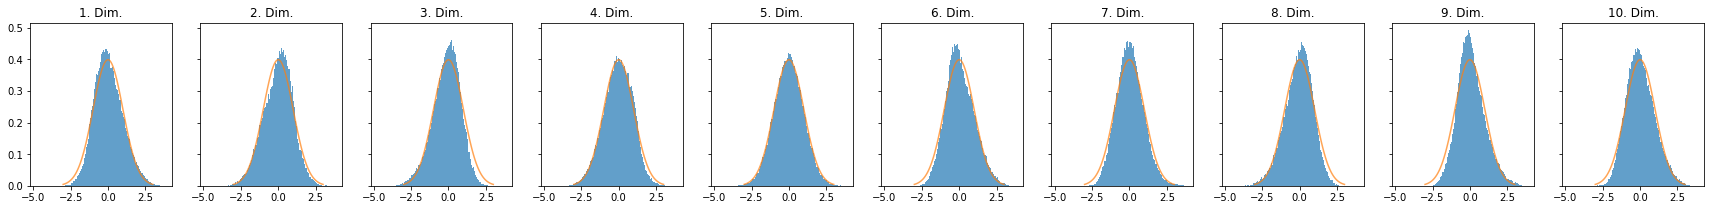

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy

rows, cols = 1, 10

predds = vae_dsprites_lf_7500.encoder.predict(np.expand_dims(imgs, -1))

fig, ax = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(cols*3, rows*3))

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
for dim in trange(predds.shape[-1]):
    ax[dim].hist(predds[:,dim], bins=100, alpha=0.7, density=True)
    ax[dim].plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=0.7)
    ax[dim].set_title("{}. Dim.".format(dim+1))
fig.show()

In [13]:
bottom_left = dsprites['imgs'][np.intersect1d(np.where(dsprites['latents_values'][:, 4] == 0.0), np.where(dsprites['latents_values'][:, 5] == 0.0))]
top_right = dsprites['imgs'][np.intersect1d(np.where(dsprites['latents_values'][:, 4] == 1.0), np.where(dsprites['latents_values'][:, 5] == 1.0))]
small_scale = dsprites['imgs'][np.where(dsprites['latents_values'][:, 2] == 0.5)]
large_scale = dsprites['imgs'][np.where(dsprites['latents_values'][:, 2] == 1.0)]

In [205]:
orientations = sorted(list(set(dsprites['latents_values'][:, 3])))
orientations = [dsprites['imgs'][np.intersect1d(np.intersect1d(np.where(dsprites['latents_values'][:, 3] == o), np.intersect1d(np.where(dsprites['latents_values'][:, 4] == 0.0), np.where(dsprites['latents_values'][:, 5] == 0.0))),np.where(dsprites['latents_values'][:, 1] == 1))] for o in tqdm(orientations)]
bottoms = sorted(list(set(dsprites['latents_values'][:, 5])))
bottoms = [dsprites['imgs'][np.intersect1d(np.intersect1d(np.where(dsprites['latents_values'][:, 4] == 1.0), np.where(dsprites['latents_values'][:, 5] == b)),np.where(dsprites['latents_values'][:, 1] == 1))] for b in tqdm(bottoms)]
lefts = sorted(list(set(dsprites['latents_values'][:, 4])))
lefts = [dsprites['imgs'][np.intersect1d(np.intersect1d(np.where(dsprites['latents_values'][:, 5] == 1.0), np.where(dsprites['latents_values'][:, 4] == b)),np.where(dsprites['latents_values'][:, 1] == 1))] for b in tqdm(lefts)]

In [256]:
scales = sorted(list(set(dsprites['latents_values'][:, 2])))
scales = [dsprites['imgs'][np.intersect1d(np.intersect1d(np.where(dsprites['latents_values'][:, 2] == o), np.intersect1d(np.where(dsprites['latents_values'][:, 4] == 0.0), np.where(dsprites['latents_values'][:, 5] == 0.0))),np.where(dsprites['latents_values'][:, 1] == 1))] for o in tqdm(scales)]
shapes = sorted(list(set(dsprites['latents_values'][:, 1])))
shapes = [dsprites['imgs'][np.intersect1d(np.where(dsprites['latents_values'][:, 1] == o), np.intersect1d(np.where(dsprites['latents_values'][:, 4] == 0.0), np.where(dsprites['latents_values'][:, 5] == 0.0)))] for o in tqdm(shapes)]

In [ ]:
bottom_left_mean = np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(bottom_left, -1)), axis=0)
top_right_mean = np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(top_right, -1)), axis=0)
small_scale_mean = np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(small_scale, -1)), axis=0)
large_scale_mean = np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(large_scale, -1)), axis=0)


In [225]:
orientations_means = [np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(o, -1)), axis=0) for o in tqdm(orientations)]
bottom_means = [np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(o, -1)), axis=0) for o in tqdm(bottoms)]
left_means = [np.mean(vae_dsprites_lf_3750.encoder.predict(np.expand_dims(o, -1)), axis=0) for o in tqdm(lefts)]

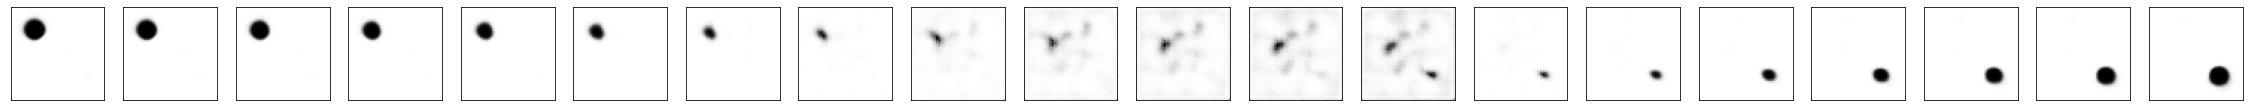

In [17]:
cols = 20

fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))

for col in range(cols):
    alpha = col / 20
    #vec = np.random.standard_normal(10)
    vec = (1-alpha)*bottom_left_mean + alpha*top_right_mean
    axs[col].imshow(1.0-vae_dsprites_lf_3750.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
    axs[col].set_xticks([])
    axs[col].set_yticks([])
plt.show(fig)

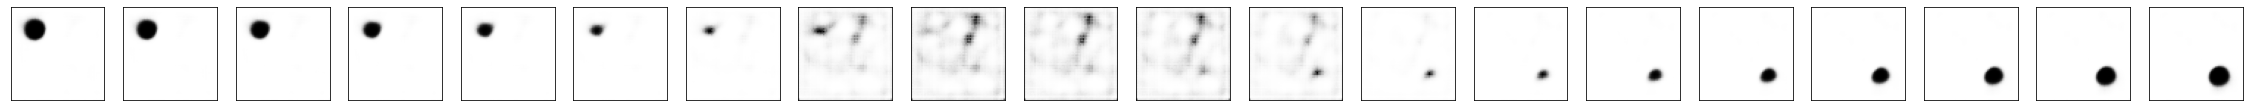

In [18]:
bottom_left_mean = np.mean(vae_dsprites_lf_5000.encoder.predict(np.expand_dims(bottom_left, -1)), axis=0)
top_right_mean = np.mean(vae_dsprites_lf_5000.encoder.predict(np.expand_dims(top_right, -1)), axis=0)
small_scale_mean = np.mean(vae_dsprites_lf_5000.encoder.predict(np.expand_dims(small_scale, -1)), axis=0)
large_scale_mean = np.mean(vae_dsprites_lf_5000.encoder.predict(np.expand_dims(large_scale, -1)), axis=0)

cols = 20

fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))

for col in range(cols):
    alpha = col / 20
    #vec = np.random.standard_normal(10)
    vec = (1-alpha)*bottom_left_mean + alpha*top_right_mean
    axs[col].imshow(1.0-vae_dsprites_lf_5000.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
    axs[col].set_xticks([])
    axs[col].set_yticks([])
plt.show(fig)

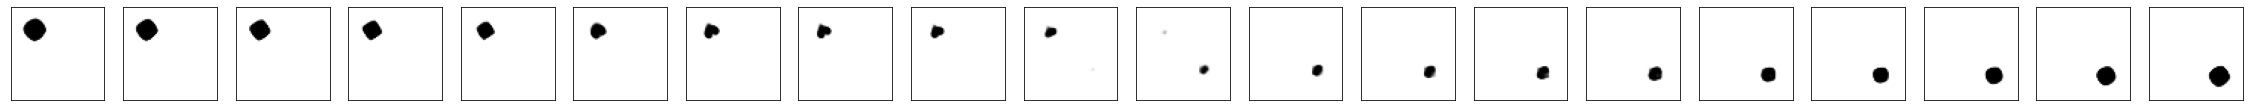

In [19]:
bottom_left_mean = np.mean(vae_dsprites_lf_6250.encoder.predict(np.expand_dims(bottom_left, -1)), axis=0)
top_right_mean = np.mean(vae_dsprites_lf_6250.encoder.predict(np.expand_dims(top_right, -1)), axis=0)
small_scale_mean = np.mean(vae_dsprites_lf_6250.encoder.predict(np.expand_dims(small_scale, -1)), axis=0)
large_scale_mean = np.mean(vae_dsprites_lf_6250.encoder.predict(np.expand_dims(large_scale, -1)), axis=0)

cols = 20

fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))

for col in range(cols):
    alpha = col / 20
    #vec = np.random.standard_normal(10)
    vec = (1-alpha)*bottom_left_mean + alpha*top_right_mean
    axs[col].imshow(1.0-vae_dsprites_lf_6250.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
    axs[col].set_xticks([])
    axs[col].set_yticks([])
plt.show(fig)

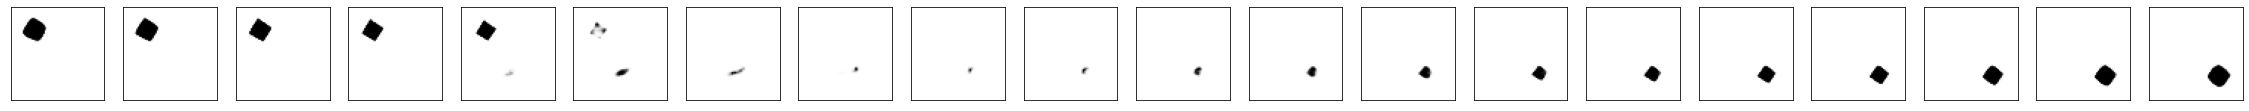

In [20]:
bottom_left_mean = np.mean(vae_dsprites_lf_7500.encoder.predict(np.expand_dims(bottom_left, -1)), axis=0)
top_right_mean = np.mean(vae_dsprites_lf_7500.encoder.predict(np.expand_dims(top_right, -1)), axis=0)
small_scale_mean = np.mean(vae_dsprites_lf_7500.encoder.predict(np.expand_dims(small_scale, -1)), axis=0)
large_scale_mean = np.mean(vae_dsprites_lf_7500.encoder.predict(np.expand_dims(large_scale, -1)), axis=0)

cols = 20

fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))

for col in range(cols):
    alpha = col / 20
    #vec = np.random.standard_normal(10)
    vec = (1-alpha)*bottom_left_mean + alpha*top_right_mean
    axs[col].imshow(1.0-vae_dsprites_lf_7500.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
    axs[col].set_xticks([])
    axs[col].set_yticks([])
plt.show(fig)

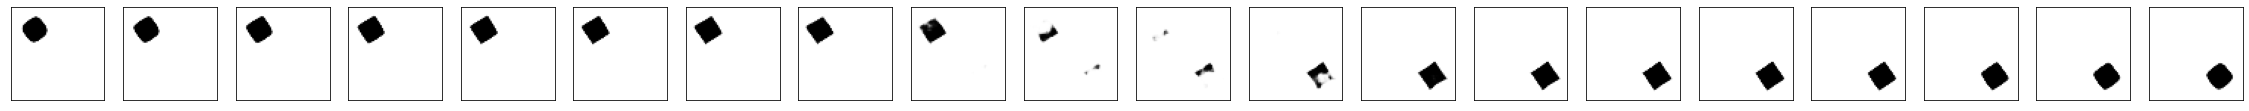

In [25]:
bottom_left_mean = np.mean(vae_dsprites.encoder.predict(np.expand_dims(bottom_left, -1)), axis=0)
top_right_mean = np.mean(vae_dsprites.encoder.predict(np.expand_dims(top_right, -1)), axis=0)
small_scale_mean = np.mean(vae_dsprites.encoder.predict(np.expand_dims(small_scale, -1)), axis=0)
large_scale_mean = np.mean(vae_dsprites.encoder.predict(np.expand_dims(large_scale, -1)), axis=0)

cols = 20

fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))

for col in range(cols):
    alpha = col / 20
    #vec = np.random.standard_normal(10)
    vec = (1-alpha)*bottom_left_mean + alpha*top_right_mean
    axs[col].imshow(1.0-vae_dsprites.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
    axs[col].set_xticks([])
    axs[col].set_yticks([])
plt.show(fig)

In [ ]:
cols = 20

fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))

for col in range(cols):
    alpha = col / 20
    #vec = np.random.standard_normal(10)
    vec = (1-alpha)*bottom_left_mean + alpha*top_right_mean
    axs[col].imshow(1.0-vae_dsprites.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
    axs[col].set_xticks([])
    axs[col].set_yticks([])
plt.show(fig)

In [ ]:
import sklearn

cols = 15

vecs = []

steps = 3

for i in trange(0,len(orientations_means), steps):
    fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))
    j = (i+steps) % len(orientations_means)
    i_mean = orientations_means[i]
    j_mean = orientations_means[j]
    
    vecs.append(j_mean - i_mean)


    for col in range(cols):
        alpha = col / cols
        #vec = np.random.standard_normal(10)
        vec = (1-alpha)*i_mean + alpha*j_mean
        axs[col].imshow(1.0-vae_dsprites.decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
        axs[col].set_xticks([])
        axs[col].set_yticks([])
    plt.show(fig)
    plt.close(fig)

/Users/leo/.local/share/virtualenvs/Master_Thesis-iDondhVg/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



(10, 2)


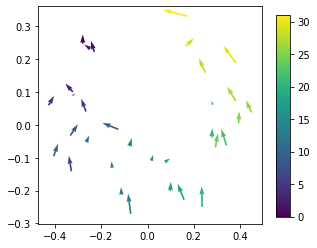

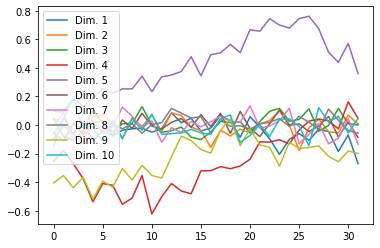


(10, 2)


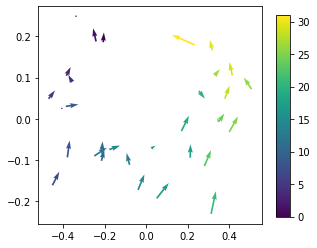

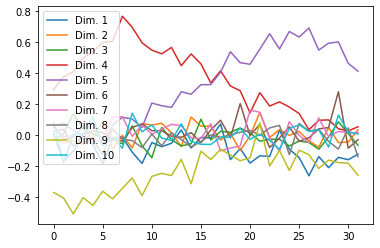


(10, 2)


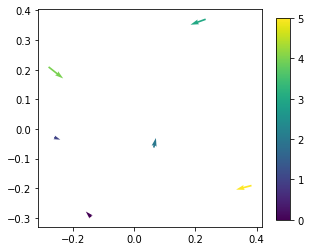

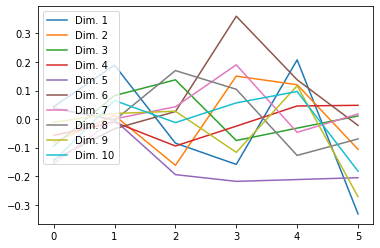


(10, 2)


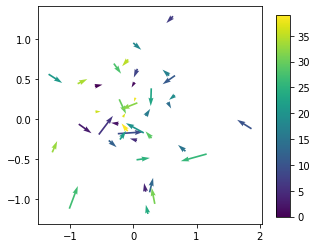

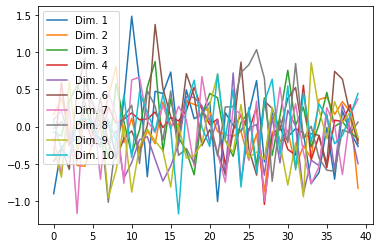


(10, 2)


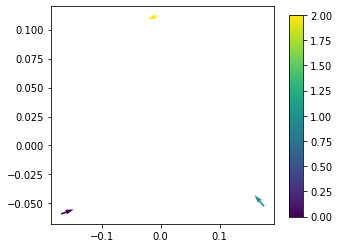

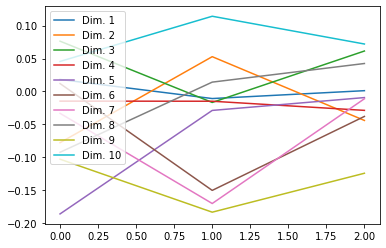

In [263]:
import sklearn

vae_gan_dsprites = keras.models.load_model("/Users/leo/Downloads/vae_gan_dsprites_zdim_10.h5")
vae_gan_dsprites_decoder = vae_gan_dsprites.layers[-1]
vae_gan_dsprites_encoder = keras.Model(vae_gan_dsprites.layers[0].input, vae_gan_dsprites.layers[-2].output)

cols = 15

for fov in [bottoms, lefts, scales, orientations,shapes]:
    
    fov_means = [np.mean(vae_gan_dsprites_encoder.predict(np.expand_dims(o, -1)), axis=0) for o in tqdm(fov)]

    vec_diffs = []
    vec_bases = []

    steps = 1

    for i in trange(0,len(fov_means), steps):
        fig, axs = plt.subplots(ncols = cols, nrows=1, figsize=(cols*2, 2))
        j = (i+steps) % len(fov_means)
        i_mean = fov_means[i]
        j_mean = fov_means[j]

        vec_diffs.append(j_mean - i_mean)
        vec_bases.append(i_mean)

        for col in range(cols):
            alpha = col / cols
            #vec = np.random.standard_normal(10)
            vec = (1-alpha)*i_mean + alpha*j_mean
            axs[col].imshow(1.0-vae_gan_dsprites_decoder.predict(np.expand_dims(vec, 0)).squeeze(), cmap='gray')
            axs[col].set_xticks([])
            axs[col].set_yticks([])
        #plt.show(fig)
        plt.close(fig)

    vec_diffs = np.array(vec_diffs)
    vec_bases = np.array(vec_bases)

    fig, ax = plt.subplots(figsize=(4, 4))

    pca = sklearn.decomposition.PCA(2)
    pca.fit(np.array(fov_means))
    vec_diffs_t = pca.transform(vec_diffs)
    vec_bases_t = pca.transform(vec_bases)
    num_vecs = vec_bases_t.shape[0]
    print(vecs_t.shape)
    q = ax.quiver(vec_bases_t[:,0], vec_bases_t[:,1], vec_diffs_t[:,0], vec_diffs_t[:, 1], np.arange(0, num_vecs, 1))

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(q, cax=cbar_ax)
    plt.show(fig)

    for i in range(10):
        plt.plot(np.arange(0, num_vecs, 1), vec_bases[:,i], label=f'Dim. {i+1}')
        plt.legend(loc=2)
    plt.show()


(32, 3, 4)
(32, 4)


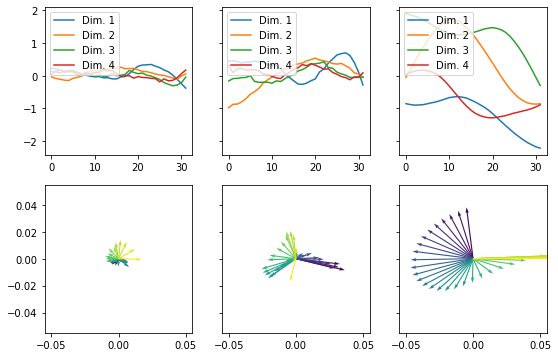

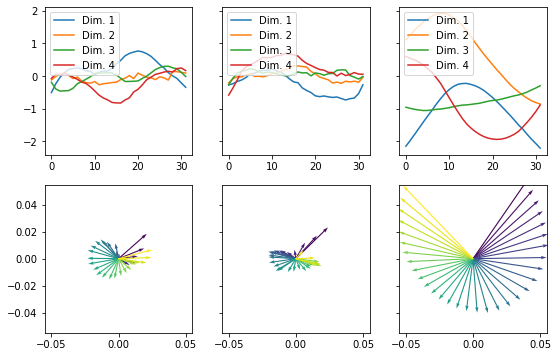

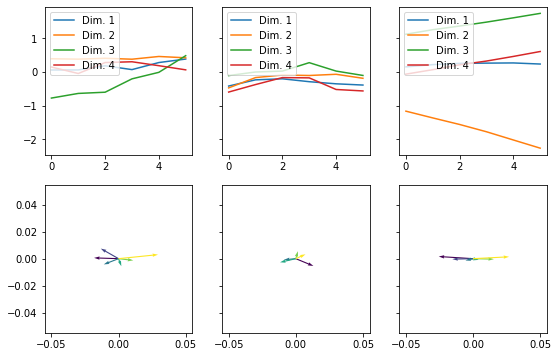

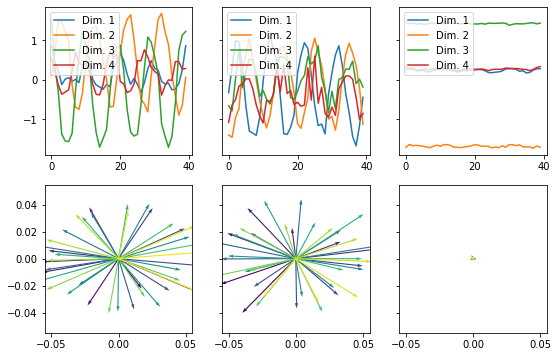

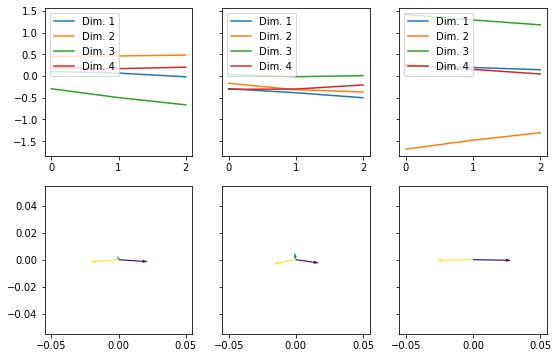

In [277]:
import numpy as np
from models.VLAE import VLAE
columns = 20
from matplotlib import pyplot as plt
rows = 20
zs = []

z_dim = 4

#vlae_gan_dsprites = keras.models.load_model("/Users/leo/Downloads/vlae_gan_dsprites_zdim_4.h5")
#vlae_gan_dsprites_decoder = vlae_gan_dsprites.layers[-1]
#vlae_gan_dsprites_encoder = keras.Model(vlae_gan_dsprites.layers[0].input, (vlae_gan_dsprites.layers[-4].output, vlae_gan_dsprites.layers[-3].output, vlae_gan_dsprites.layers[-2].output))


vlae_dsprites = VLAE(input_dim=(64, 64, 1), log_dir='',
                         inf0_kernels_strides_featuremaps=[(4, 2, 32), (4, 1, 32)],
                         inf1_kernels_strides_featuremaps=[(4, 2, 64), (4, 1, 64)],
                         ladder0_kernels_strides_featuremaps=[(4, 2, 128), (4, 1, 128)],
                         ladder1_kernels_strides_featuremaps=[(4, 2, 256), (4, 1, 256)],
                         ladder2_kernels_strides_featuremaps=[(4, 2, 256), (4, 2, 512), (4, 2, 1024)],
                         gen2_num_units=[1024, 1024],
                         gen1_num_units=[1024, 1024],
                         gen0_kernels_strides_featuremaps=[(4, 2, 1024), (4, 2, 512), (4, 2, 256),
                                                           (4, 2, 128), (4, 2, 1)],
                         kernel_visualization_layer=1, num_samples=5,
                         feature_map_layers=[], inner_activation='ReLU',
                         decay_rate=.0, feature_map_reduction_factor=1,
                         z_dims=[z_dim]*3, dropout_rate=.0, use_dropout=False,
                         use_batch_norm=True)
vlae_dsprites.load_weights('/Users/leo/Downloads/vlae_64_dsprites_zdim_4.h5')


bottom_means = [[np.mean(a, axis=0) for a in vlae_dsprites.encoder.predict(np.expand_dims(o, -1))] for o in tqdm(bottoms)]
bottom_means = np.array(bottom_means)
print(bottom_means.shape)
print(bottom_means[:,col,:].shape)
lefts_means = [[np.mean(a, axis=0) for a in vlae_dsprites.encoder.predict(np.expand_dims(o, -1))] for o in tqdm(lefts)]
lefts_means = np.array(lefts_means)
scales_means = [[np.mean(a, axis=0) for a in vlae_dsprites.encoder.predict(np.expand_dims(o, -1))] for o in tqdm(scales)]
scales_means = np.array(scales_means)
orientations_means = [[np.mean(a, axis=0) for a in vlae_dsprites.encoder.predict(np.expand_dims(o, -1))] for o in tqdm(orientations)]
orientations_means = np.array(orientations_means)
shapes_means = [[np.mean(a, axis=0) for a in vlae_dsprites.encoder.predict(np.expand_dims(o, -1))] for o in tqdm(shapes)]
shapes_means = np.array(shapes_means)

scale=3

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), sharey='row')
for col in trange(3):
    pca = sklearn.decomposition.PCA(2)
    pca.fit(bottom_means[:,col,:])
    for i in range(z_dim):
        axs[0,col].plot(np.arange(0, len(bottom_means), 1), bottom_means[:,col,i], label=f'Dim. {i+1}')
        axs[0,col].legend(loc=2) 
    axs[1,col].quiver([0]*bottom_means.shape[0], [0]*bottom_means.shape[0], pca.transform(bottom_means[:,col,:])[:,0], pca.transform(bottom_means[:,col,:])[:,1], np.arange(0, bottom_means.shape[0], 1), scale=scale)
plt.show(fig)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), sharey='row')
for col in trange(3):
    pca = sklearn.decomposition.PCA(2)
    pca.fit(lefts_means[:,col,:])
    for i in range(z_dim):
        axs[0,col].plot(np.arange(0, len(lefts_means), 1), lefts_means[:,col,i], label=f'Dim. {i+1}')
        axs[0,col].legend(loc=2) 
    axs[1,col].quiver([0]*lefts_means.shape[0], [0]*lefts_means.shape[0], pca.transform(lefts_means[:,col,:])[:,0], pca.transform(lefts_means[:,col,:])[:,1], np.arange(0, lefts_means.shape[0], 1), scale=scale)
plt.show(fig)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), sharey='row')
for col in trange(3):
    pca = sklearn.decomposition.PCA(2)
    pca.fit(scales_means[:,col,:])
    for i in range(z_dim):
        axs[0,col].plot(np.arange(0, len(scales_means), 1), scales_means[:,col,i], label=f'Dim. {i+1}')
        axs[0,col].legend(loc=2) 
    axs[1,col].quiver([0]*scales_means.shape[0], [0]*scales_means.shape[0], pca.transform(scales_means[:,col,:])[:,0], pca.transform(scales_means[:,col,:])[:,1], np.arange(0, scales_means.shape[0], 1), scale=scale)
plt.show(fig)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), sharey='row')
for col in trange(3):
    pca = sklearn.decomposition.PCA(2)
    pca.fit(orientations_means[:,col,:])
    for i in range(z_dim):
        axs[0,col].plot(np.arange(0, len(orientations_means), 1), orientations_means[:,col,i], label=f'Dim. {i+1}')
        axs[0,col].legend(loc=2) 
    axs[1,col].quiver([0]*orientations_means.shape[0], [0]*orientations_means.shape[0], pca.transform(orientations_means[:,col,:])[:,0], pca.transform(orientations_means[:,col,:])[:,1], np.arange(0, orientations_means.shape[0], 1), scale=scale)
plt.show(fig)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), sharey='row')
for col in trange(3):
    pca = sklearn.decomposition.PCA(2)
    pca.fit(shapes_means[:,col,:])
    for i in range(z_dim):
        axs[0,col].plot(np.arange(0, len(shapes_means), 1), shapes_means[:,col,i], label=f'Dim. {i+1}')
        axs[0,col].legend(loc=2) 
    axs[1,col].quiver([0]*shapes_means.shape[0], [0]*shapes_means.shape[0], pca.transform(shapes_means[:,col,:])[:,0], pca.transform(shapes_means[:,col,:])[:,1], np.arange(0, shapes_means.shape[0], 1), scale=1)
plt.show(fig)


In [260]:
lefts_means.shape

(32, 3, 4)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

#pca = sklearn.decomposition.PCA(2)
#pca.fit(np.array(orientations_means))
vecs_t = pca.transform(orientations_means)
num_vecs = vecs_t.shape[0]
vecs_t = vecs_t[:num_vecs//4]
num_vecs = vecs_t.shape[0]
print(vecs_t.shape)
q = ax.quiver([0]*num_vecs, [0]*num_vecs, vecs_t[:, 0], vecs_t[:, 1], np.arange(0, num_vecs, 1), scale=4)

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(q, cax=cbar_ax)
plt.show(fig)

In [ ]:
vecs_shape_1_scale_0_5 = vae_dsprites_lf_3750.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 1.00, Scale 0.50' in k[0]])[0]], -1))
vecs_shape_2_scale_0_5 = vae_dsprites_lf_3750.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 2.00, Scale 0.50' in k[0]])[0]], -1))
vecs_shape_3_scale_0_5 = vae_dsprites_lf_3750.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 3.00, Scale 0.50' in k[0]])[0]], -1))

In [ ]:
rows, cols = 1, 21


fig = plt.figure(figsize=(cols, rows))

n_plots = rows * cols

smpl = 1

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_1_scale_0_5[smpl] + tau*(vecs_shape_2_scale_0_5[smpl]-vecs_shape_1_scale_0_5[smpl])
    img = vae_dsprites_lf_7500.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_2_scale_0_5[smpl] + tau*(vecs_shape_3_scale_0_5[smpl]-vecs_shape_2_scale_0_5[smpl])
    img = vae_dsprites_lf_7500.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_3_scale_0_5[smpl] + tau*(vecs_shape_1_scale_0_5[smpl]-vecs_shape_3_scale_0_5[smpl
])
    img = vae_dsprites_lf_7500.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
import math, scipy
rows, cols = 1, 10

predds = vae_dsprites_lf_5000.encoder.predict(np.expand_dims(imgs, -1))

fig, ax = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(cols*3, rows*3))
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
for dim in trange(predds.shape[-1]):
    ax[dim].hist(predds[:,dim], bins=100, alpha=0.7, density=True)
    ax[dim].plot(x, scipy.stats.norm.pdf(x, mu, sigma), alpha=0.7)
    ax[dim].set_title("{}. Dim.".format(dim+1))
fig.show()

In [ ]:
vecs_shape_1_scale_0_5 = vae_dsprites_lf_5000.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 1.00, Scale 0.50' in k[0]])[0]], -1))
vecs_shape_2_scale_0_5 = vae_dsprites_lf_5000.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 2.00, Scale 0.50' in k[0]])[0]], -1))
vecs_shape_3_scale_0_5 = vae_dsprites_lf_5000.encoder.predict(np.expand_dims(imgs[np.array([k[1] for k in shape_and_scale if 'Shape 3.00, Scale 0.50' in k[0]])[0]], -1))

In [ ]:
rows, cols = 1, 21

factor = 1.5 / np.max(aaa)

fig = plt.figure(figsize=(cols, rows))

n_plots = rows * cols

smpl = 1

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_1_scale_0_5[smpl] + tau*(vecs_shape_2_scale_0_5[smpl]-vecs_shape_1_scale_0_5[smpl])
    img = vae_dsprites_lf_5000.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_2_scale_0_5[smpl] + tau*(vecs_shape_3_scale_0_5[smpl]-vecs_shape_2_scale_0_5[smpl])
    img = vae_dsprites_lf_5000.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_3_scale_0_5[smpl] + tau*(vecs_shape_1_scale_0_5[smpl]-vecs_shape_3_scale_0_5[smpl
])
    img = vae_dsprites_lf_5000.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
rows, cols = 1, 21

factor = 1.5 / np.max(aaa)

fig = plt.figure(figsize=(cols, rows))

n_plots = rows * cols

smpl = 1

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_1_scale_0_5[smpl] + tau*(vecs_shape_2_scale_0_5[smpl]-vecs_shape_1_scale_0_5[smpl])
    img = vae_dsprites_lf_3750.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_2_scale_0_5[smpl] + tau*(vecs_shape_3_scale_0_5[smpl]-vecs_shape_2_scale_0_5[smpl])
    img = vae_dsprites_lf_3750.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(cols, rows))

for i in range(n_plots):
    tau = i/(n_plots-1)
    arr = vecs_shape_3_scale_0_5[smpl] + tau*(vecs_shape_1_scale_0_5[smpl]-vecs_shape_3_scale_0_5[smpl
])
    img = vae_dsprites_lf_3750.decoder.predict(np.expand_dims(arr, axis=0)).squeeze()
    #img = vae_dsprites.decoder.predict(np.random.standard_normal(size=(1, 10))).squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(1.0-img, cmap='gray')
    plt.axis('off')
plt.show()

In [278]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import SGD, Adam
import keras


x = inpt = Input(shape=(64, 64, 1), name="discriminator_input")
x = Conv2D(batch_input_shape=(64, 64, 1), filters=64, kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(batch_input_shape=(64, 64, 1), filters=128, kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = x_feat = Conv2D(batch_input_shape=(64, 64, 1), filters=256, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = x_feat = Conv2D(batch_input_shape=(64, 64, 1), filters=512, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(batch_input_shape=(64, 64, 1), filters=3, kernel_size=1, strides=3, padding='same')(x)
x = Flatten()(x)
x = Dense(3)(x)
x = Activation(activation='softmax')(x)
perc_loss = Model(inpt, x_feat, name="perceptual_network")
perc_loss_train = Model(inpt, x, name="perceptual_train_network")

perc_loss_train.compile(Adam(lr=0.01), keras.losses.categorical_crossentropy, ['categorical_accuracy'])


In [279]:
import sklearn

dsprites_train_imgs, dsprites_test_imgs, dsprites_train_lv,dsprites_test_lv = sklearn.model_selection.train_test_split(dsprites['imgs'], dsprites['latents_values'], random_state=42,  test_size=0.1)

In [280]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y = enc.fit_transform(dsprites_train_lv[:,1].reshape(-1, 1))

print(dsprites_train_imgs.shape)
y = y.astype(np.float32)

perc_loss_train.fit(x=np.expand_dims(dsprites_train_imgs, -1), y=y, batch_size=128, epochs=1)

(663552, 64, 64)
Epoch 1/1
663552/663552 [==============================] - 6377s 10ms/step - loss: 0.3554 - categorical_accuracy: 0.8238


In [281]:
perc_loss_train.evaluate(np.expand_dims(dsprites_test_imgs, -1), enc.transform(dsprites_test_lv[:,1].reshape(-1, 1)))

73728/73728 [==============================] - 237s 3ms/step


[0.7356769138859818, 0.8150227864583334]

In [282]:
import numpy as np
from utils.img_ops import resize_array
import pickle
import urllib

def distance_measure(y1, y2):
    feat_1 = perc_loss.predict(y1)
    feat_2 = perc_loss.predict(y2)
    squared_difference = np.square(feat_1-feat_2)
    return np.mean(squared_difference, axis=(1,2,3))

def normalize(v):
    im = np.sqrt(np.sum(np.square(v), axis=-1, keepdims=True))
    return v / im

def slerp(a, b, t):
    a = normalize(a)
    b = normalize(b)
    d = np.sum(a * b, axis=-1, keepdims=True)
    p = t * np.arccos(d)
    c = normalize(b - d * a)
    d = a * np.cos(p) + c * np.sin(p)
    return normalize(d)

def perceptual_path_length(decoder, num_samples = 100, minibatch=32, sampling = 'full', epsilon=1e-4, seed=None):
    distance_expr = []
    for begin in range(0, num_samples, minibatch):
        if seed is not None:
            np.random.seed(begin*seed)
        lat_t01 = np.random.standard_normal([minibatch * 2] + decoder.inputs[0].shape[1:])
        lerp_t = np.random.uniform(size=[minibatch], low=0.0, high=1.0 if sampling == 'full' else 0.0)
        lat_t0, lat_t1 = lat_t01[0::2], lat_t01[1::2]
        lat_e0 = slerp(lat_t0, lat_t1, lerp_t[:, np.newaxis])
        lat_e1 = slerp(lat_t0, lat_t1, lerp_t[:, np.newaxis] + epsilon)
        dlat_e01 = np.reshape(np.stack([lat_e0, lat_e1], axis=1), lat_t01.shape)
        images = decoder.predict(dlat_e01)

        img_e0, img_e1 = images[0::2], images[1::2]

        distance_expr.append(distance_measure(img_e0, img_e1) * (1 / epsilon**2))
    all_distances = np.concatenate(distance_expr, axis=0)
    #lo = np.percentile(all_distances, 1, interpolation='lower')
    #hi = np.percentile(all_distances, 99, interpolation='higher')
    #filtered_distances = np.extract(np.logical_and(lo <= all_distances, all_distances <= hi), all_distances)
    return np.mean(all_distances), all_distances
        

    

In [285]:
import scipy as sp

lf_10000_means, lf_7500_means, lf_6250_means, lf_5000_means, lf_3750_means = [], [], [], [], []

for i in trange(200):
    lf_10000_mean, _ = perceptual_path_length(vae_dsprites.decoder, seed=i)
    lf_7500_mean, _ = perceptual_path_length(vae_dsprites_lf_7500.decoder, seed=i)
    lf_6250_mean, _ = perceptual_path_length(vae_dsprites_lf_6250.decoder, seed=i)
    lf_5000_mean, _ = perceptual_path_length(vae_dsprites_lf_5000.decoder, seed=i)
    lf_3750_mean, _ = perceptual_path_length(vae_dsprites_lf_3750.decoder, seed=i)
    lf_10000_means.append(lf_10000_mean)
    lf_6250_means.append(lf_6250_mean)
    lf_7500_means.append(lf_7500_mean)
    lf_5000_means.append(lf_5000_mean)
    lf_3750_means.append(lf_3750_mean)

print("10,000 vs 7,500: {}".format(sp.stats.wilcoxon(lf_10000_means, lf_7500_means)))
print("10,000 vs 6,250: {}".format(sp.stats.wilcoxon(lf_10000_means, lf_6250_means)))
print("10,000 vs 5,000: {}".format(sp.stats.wilcoxon(lf_10000_means, lf_5000_means)))
print("10,000 vs 3,750: {}".format(sp.stats.wilcoxon(lf_10000_means, lf_3750_means)))
print("7,500 vs 6,250: {}".format(sp.stats.wilcoxon(lf_7500_means, lf_6250_means)))
print("7,500 vs 5,000: {}".format(sp.stats.wilcoxon(lf_7500_means, lf_5000_means)))
print("7,500 vs 3,750: {}".format(sp.stats.wilcoxon(lf_7500_means, lf_3750_means)))
print("6,250 vs 5,000: {}".format(sp.stats.wilcoxon(lf_6250_means, lf_5000_means)))
print("6,250 vs 3,750: {}".format(sp.stats.wilcoxon(lf_6250_means, lf_3750_means)))
print("5,000 vs 3,750: {}".format(sp.stats.wilcoxon(lf_5000_means, lf_3750_means)))


#vae_dsprites_lf_5000.decoder.inputs[0]


10,000 vs 7,500: WilcoxonResult(statistic=184.0, pvalue=2.2378794122028128e-33)
10,000 vs 6,250: WilcoxonResult(statistic=14.0, pvalue=1.7729943823825292e-34)
10,000 vs 5,000: WilcoxonResult(statistic=259.0, pvalue=6.756591813099692e-33)
10,000 vs 3,750: WilcoxonResult(statistic=925.0, pvalue=8.565057092070983e-29)
7,500 vs 6,250: WilcoxonResult(statistic=314.0, pvalue=1.5113036943272736e-32)
7,500 vs 5,000: WilcoxonResult(statistic=0.0, pvalue=1.4361464127613523e-34)
7,500 vs 3,750: WilcoxonResult(statistic=0.0, pvalue=1.4361464127613523e-34)
6,250 vs 5,000: WilcoxonResult(statistic=0.0, pvalue=1.4361464127613523e-34)
6,250 vs 3,750: WilcoxonResult(statistic=0.0, pvalue=1.4361464127613523e-34)
5,000 vs 3,750: WilcoxonResult(statistic=422.0, pvalue=7.248261845521067e-32)


In [286]:
print("mu={}, std={}".format(np.mean(lf_10000_means),np.std(lf_10000_means)))
print("mu={}, std={}".format(np.mean(lf_7500_means),np.std(lf_7500_means)))
print("mu={}, std={}".format(np.mean(lf_6250_means),np.std(lf_6250_means)))
print("mu={}, std={}".format(np.mean(lf_5000_means),np.std(lf_5000_means)))
print("mu={}, std={}".format(np.mean(lf_3750_means),np.std(lf_3750_means)))

mu=936.2572631835938, std=779.09814453125
mu=2834.67431640625, std=567.9329223632812
mu=4498.15625, std=1091.2550048828125
mu=173.5329132080078, std=35.8962516784668
mu=258.3259582519531, std=49.117095947265625


In [ ]:
print(dsprites_test_imgs.max())
for ds_vae in tqdm([vae_dsprites, vae_dsprites_lf_7500, vae_dsprites_lf_6250, vae_dsprites_lf_5000, vae_dsprites_lf_3750]):
    vae_predictions = np.array(ds_vae.encoder.predict(np.expand_dims(dsprites_test_imgs[:10000], -1)))
    vae_kdes = np.array([stats.gaussian_kde(vae_predictions[:, i]) for i in range(vae_predictions.shape[-1])])
    vae_latent_samples = np.array([vae_kdes[i].resample(10000).ravel() for i in range(vae_kdes.shape[0])])
    vae_latent_samples = np.swapaxes(vae_latent_samples, 0, -1)
    
    fig, ax = plt.subplots(1, vae_predictions.shape[-1], figsize=(vae_predictions.shape[-1]*5, 5))
    print("=========================================================")
    for dim in range(vae_predictions.shape[-1]):
        ax[dim].hist(vae_predictions[:, dim], bins=100, density=True, label='True', alpha=0.5)
        ax[dim].hist(vae_latent_samples[:, dim], bins=100, density=True, label='Resampled', alpha=0.5)
        print(sp.stats.mannwhitneyu(vae_predictions[:, dim], vae_latent_samples[:, dim]))
    plt.show(fig)
    '''
    vae_gens_resampling = ds_vae.decoder.predict(vae_latent_samples).squeeze()
    vae_gens_resampling = np.stack(vae_gens_resampling)
    vae_gens_resampling *= 255.0
    vae_gens_resampling = vae_gens_resampling.reshape(vae_gens_resampling.shape[0], -1)
    vae_gens_resamplingling_mean = np.mean(vae_gens_resampling, axis=1)
    vae_gens_resampling_sd = np.std(vae_gens_resampling, axis=1)
    vae_gens_resampling_skew = sp.stats.skew(vae_gens_resampling, axis=1)
    vae_gens_resampling_kurt = sp.stats.kurtosis(vae_gens_resampling, axis=1)
    
    vae_gens_reconstr = ds_vae.decoder.predict(vae_predictions).squeeze()
    vae_gens_reconstr = np.stack(vae_gens_reconstr)
    vae_gens_reconstr *= 255.0
    vae_gens_reconstr = vae_gens_reconstr.reshape(vae_gens_reconstr.shape[0], -1)
    vae_gens_reconstr_mean = np.mean(vae_gens_reconstr, axis=1)
    vae_gens_reconstr_sd = np.std(vae_gens_reconstr, axis=1)
    vae_gens_reconstr_skew = sp.stats.skew(vae_gens_reconstr, axis=1)
    vae_gens_reconstr_kurt = sp.stats.kurtosis(vae_gens_reconstr, axis=1)
    '''


# CELEBA - LATENT SPACE TRAVERSAL

In [ ]:
vae_celeba = keras.models.load_model("/Users/leo/Downloads/vlae_gan_128_celeba.h5")
vlae_gan_celeba_decoder = vlae_gan_celeba.layers[-1]

In [ ]:
fig = plt.figure(figsize=(81, 27))
outer = fig.add_gridspec(1, 3, wspace=0.2, hspace=0.2)


for col in trange(3):
    inner = outer[col].subgridspec(20, 20, wspace=0.1, hspace=0.1)
    for i in range(400):
        ax = fig.add_subplot(inner[i])
        z = [np.random.uniform(-3,3,(1,2))] * 3
        z[col] = zs[i]
        img = vlae_gan_celeba_decoder.predict(z).squeeze()
        ax.imshow(img)
        ax.axis('off')
        fig.add_subplot(ax)
plt.show()

In [ ]:
vae_celeba = VAE(input_dim=(128, 128, 3), encoder_conv_filters=[32, 64, 128, 256, 512],
                        encoder_conv_kernel_size=[4, 4, 4, 4, 4], encoder_conv_strides=[2, 2, 2, 2, 1],
                        decoder_conv_t_filters=[512, 256, 128, 3],
                        decoder_conv_t_kernel_size=[4, 4, 4, 4, 4],
                        decoder_conv_t_strides=[2, 2, 2, 2, 1], log_dir='', z_dims=[8],
                        kernel_visualization_layer=1,
                        feature_map_layers=[], use_batch_norm=False,
                        decay_rate=.0, num_samples=5,
                        feature_map_reduction_factor=1,
                        inner_activation='ReLU', dropout_rate=.0)

vae_celeba.load_weights("/Users/leo/Downloads/vae_128_celeba.h5")
vae_gan_celeba_decoder = vae_gan_celeba.layers[-1]
vae_gan_celeba_encoder = Model(vae_gan_celeba.layers[0].input, vae_gan_celeba.layers[-2].output)

In [ ]:
plt.imshow(vae_celeba.decoder.predict(np.random.standard_normal((1,8))).squeeze())

In [ ]:
celeba_attrs = {}
celeba_headers = []

with open(os.path.join('/Users/leo/Downloads/29561_37705_bundle_archive/list_attr_celeba.csv'), newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
    for i, row in enumerate(spamreader):
        if i == 0:
            print(row)
            for header in row:
                celeba_attrs.setdefault(header, [])
                celeba_headers.append(header)
        else:
            for j, cell in enumerate(row):
                celeba_attrs[celeba_headers[j]].append(cell)

In [ ]:
celeba_attrs.keys()

In [ ]:
male_ids = np.where(np.array(celeba_attrs['Male']) == '1')[0]
female_ids = np.where(np.array(celeba_attrs['Male']) == '-1')[0]
blond_hair_ids = np.where(np.array(celeba_attrs['Blond_Hair']) == '1')[0]
black_hair_ids = np.where(np.array(celeba_attrs['Black_Hair']) == '1')[0]
glasses_ids = np.where(np.array(celeba_attrs['Eyeglasses']) == '1')[0]

In [ ]:
np.random.shuffle(male_ids)
np.random.shuffle(female_ids)
np.random.shuffle(blond_hair_ids)
np.random.shuffle(black_hair_ids)
np.random.shuffle(glasses_ids)

In [ ]:
import os
from PIL import Image

from skimage.io import imread

def image_generator(directory, idxs, batch_size = 64):
    files = os.listdir(directory)
    files = np.array(celeba_attrs['image_id'])[np.array(idxs)].flatten()
    
    num_batch = 0
    while True:
        # Select files (paths/indices) for the batch
        batch_paths  = files[num_batch*batch_size:(num_batch+1)*batch_size]
        batch_input  = []
          
        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            img = np.array(Image.open(os.path.join(directory, input_path)).resize((128,128))) / 255.0
            
            # input = preprocess_input(image=input)
            batch_input += [ img ]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array( batch_input )
        num_batch += 1
        
        yield batch_x

In [ ]:
male_generator = image_generator('/Users/leo/Downloads/29561_37705_bundle_archive/img_align_celeba/img_align_celeba',male_ids, 32)
female_generator = image_generator('/Users/leo/Downloads/29561_37705_bundle_archive/img_align_celeba/img_align_celeba',female_ids, 32)
blond_hair_generator = image_generator('/Users/leo/Downloads/29561_37705_bundle_archive/img_align_celeba/img_align_celeba',blond_hair_ids, 32)
black_hair_generator = image_generator('/Users/leo/Downloads/29561_37705_bundle_archive/img_align_celeba/img_align_celeba',black_hair_ids, 32)
glasses_generator = image_generator('/Users/leo/Downloads/29561_37705_bundle_archive/img_align_celeba/img_align_celeba',glasses_ids, 32)
no_glasses_generator = image_generator('/Users/leo/Downloads/29561_37705_bundle_archive/img_align_celeba/img_align_celeba',no_glasses_ids, 32)


In [ ]:
male_preds = vae_celeba.encoder.predict_generator(male_generator, steps = 100)
female_preds = vae_celeba.encoder.predict_generator(female_generator, steps = 100)
blond_hair_preds = vae_celeba.encoder.predict_generator(blond_hair_generator, steps = 100)
black_hair_preds = vae_celeba.encoder.predict_generator(black_hair_generator, steps = 100)
glasses_preds = vae_celeba.encoder.predict_generator(glasses_generator, steps = 100)
no_glasses_preds = vae_celeba.encoder.predict_generator(no_glasses_generator, steps = 100)

In [ ]:
male_vec = np.mean(male_preds, axis=0)
female_vec = np.mean(female_preds, axis=0)
blond_hair_vec = np.mean(blond_hair_preds, axis=0)
black_hair_vec = np.mean(black_hair_preds, axis=0)
glasses_vec = np.mean(glasses_preds, axis=0)
no_glasses_vec = np.mean(no_glasses_preds, axis=0)

In [ ]:
black_hair_woman = black_hair_preds[1]


In [ ]:
plt.imshow(vae_celeba.decoder.predict(np.expand_dims(black_hair_preds[1], 0)).squeeze())

In [ ]:
plt.imshow(vae_celeba.decoder.predict(np.expand_dims(black_hair_woman - black_hair_vec + 1.*blond_hair_vec, 0)).squeeze())

In [ ]:
fig, ax = plt.subplots(1, 20, figsize=(40,4))
for dim in range(20):
    ax[dim].imshow(vae_celeba.decoder.predict(np.expand_dims(black_hair_woman -  male_vec + (dim/5)*female_vec, 0)).squeeze())
    ax[dim].set_xticks([])
    ax[dim].set_yticks([])

In [ ]:
s = np.random.standard_normal((1,8))
plt.imshow(vae_celeba.decoder.predict(s).squeeze())

In [ ]:
fig, ax = plt.subplots(1, 20, figsize=(40,4))
for dim in range(20):
    ax[dim].imshow(vae_celeba.decoder.predict(np.expand_dims(s[0] +  (dim/5)*male_vec, 0)).squeeze())
    ax[dim].set_xticks([])
    ax[dim].set_yticks([])